In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import astropy.units as u
import numpy as np
import tracemalloc
import time
import matplotlib.pyplot as plt
from scipy import special
import os.path

In [6]:
def guillot_pt(Teq, T_int,grav, logg1, logKir, alpha,nlevel, p_bottom, p_top):
    kv1, kv2 =10.**(logg1+logKir),10.**(logg1+logKir)
    kth=10.**logKir

    Teff = T_int
    f = 1.0  # solar re-radiation factor
    A = 0.0  # planetary albedo
    g0 = grav #cm/s2 to m/s2

    # Compute equilibrium temperature and set up gamma's
    T0 = Teq
    gamma1 = kv1/kth #Eqn. 25
    gamma2 = kv2/kth

    # Initialize arrays
    logtau =np.arange(-10,20,.1)
    tau =10**logtau

    #computing temperature
    T4ir = 0.75*(Teff**(4.))*(tau+(2.0/3.0))
    f1 = 2.0/3.0 + 2.0/(3.0*gamma1)*(1.+(gamma1*tau/2.0-1.0)*np.exp(-gamma1*tau))+2.0*gamma1/3.0*(1.0-tau**2.0/2.0)*special.expn(2.0,gamma1*tau)
    f2 = 2.0/3.0 + 2.0/(3.0*gamma2)*(1.+(gamma2*tau/2.0-1.0)*np.exp(-gamma2*tau))+2.0*gamma2/3.0*(1.0-tau**2.0/2.0)*special.expn(2.0,gamma2*tau)

    T4v1=f*0.75*T0**4.0*(1.0-alpha)*f1
    T4v2=f*0.75*T0**4.0*alpha*f2
    T=(T4ir+T4v1+T4v2)**(0.25)
    P=tau*g0/(kth*0.1)/1.E5

    logP = np.linspace(p_top,p_bottom,nlevel)
    newP = 10.0**logP
    T = np.interp(logP,np.log10(P),T)
    
    return T   

In [7]:
def run_planet(T_int,grav,a,T_star,logg,metal,rstar,mh,CtoO,rfacv):
    mh = mh
    CtoO = CtoO

    filename_db="/Users/sagnickmukherjee/Documents/GitHub/picaso-dev/reference/opacities/ck_cx_cont_opacities.db"
    ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/m'+mh+'_co'+CtoO+'.data.196'

    
    path = "/Users/sagnickmukherjee/Documents/research/geers/wasp39b"
    file_path= path+"/tpfile/tp_eq_planet_300_grav_4.5_mh_+0.0_CO_1.5_sm_0.0486_v_0.5_.dat"
    pressure,temp_guess = np.loadtxt(file_path,usecols=[0,1],unpack=True)
    pressure= np.logspace(-6,np.log10(3e3),91)
    opacity_ck = jdi.opannection(ck=True, ck_db=ck_db,filename_db=filename_db)#, deq = True, first_deq = True)


    # planet prop
    semi_major = a #0.0355 #"NA" # AU
    T_eff = T_int
    grav = grav
    r_planet = 1 # needed for vulcan photochem runs

    ### star prop
    T_star = T_star
    logg = logg
    metal = metal
    r_star = rstar




    nlevel = 91
    #pressure=np.logspace(np.log10(1e-6),np.log10(200.0),nlevel)
    #temp_guess = np.zeros(shape=(nlevel)) 
    kz = np.zeros(shape =(nlevel))
    #pressure_dummy,temp_guess,t1,t2,t3,t4 = np.loadtxt("/data/users/samukher/Disequilibrium-picaso/structures_m+0.0/t"+str(round(600/100.0)*100)+"g"+str(31)+"nc_m0.0.dat",usecols=[1,2,3,4,5,6],unpack=True, skiprows = 1)
    #Teq = T_star*np.sqrt(rstar/(2*semi_major*216))
    #temp_guess = guillot_pt(Teq=Teq, T_int=T_int,grav=grav, logg1=-1, logKir=-1.5, alpha=0.5,nlevel=91, p_bottom = np.log10(np.max(pressure)), p_top =np.log10(np.min(pressure)))

    #pdummy,temp_guess = np.loadtxt(path+"tpfile/tp_eq_planet_200_grav_4.5_mh_+0.0_CO_0.5_sm_0.0486_v_0.5_.dat",usecols=[0,1],unpack=True)
    
    nofczns = 1
    '''
    if mh == '+0.0':
        nstr1 = 81
    elif mh == '+0.5':
        nstr1= 78
    elif mh == '+1.0':
        nstr1 = 75
    elif mh == '+2.0':
        nstr1 = 70
    elif mh == '-0.5':
        nstr1 = 83
    elif mh == '-1.0':
        nstr1 = 85
    '''
    nstr1 = 87
    nstr = np.array([0,nstr1,89,0,0,0])
    rfacv = rfacv
    rfaci =1.0
    cloudy = False
    fsed = 2




    ###### run start

    cl_run = jdi.inputs(calculation="planet", climate = True)

    cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

    cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)'))
    cl_run.T_eff(Teff=T_eff)





    cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed, T_star = T_star, logg = logg, metal = metal, r_star = r_star, semi_major = semi_major)

    #tracemalloc.start()
    t0 = time.time()
    pressure , temp, dtdp, nstr_new, flux_plus_final, df, all_profiles = cl_run.run_climate_model(opacity_ck,save_all_profiles=True,diseq_chem = False, self_consistent_kzz =False, kz = kz )
    t1 = time.time()
    print(t1-t0)

    quench_levels=np.array([0,0,0,0])
    path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b/"

    filename= path+"tpfile/tp_eq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(filename, np.transpose([pressure,temp]), header= str("nstr "+str(nstr_new)+" T_eff "+str(T_eff)+" grav "+ str(grav)+" kz "+str(kz[0])+" T_star "+str(T_star)+" semi-major[AU] "+str(semi_major)))        

    csv = path+"profile/profile_eq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    df.to_csv(csv,sep='\t')

    hist = path+"hist/hist_eq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(hist, all_profiles)

    return t1-t0



def run_planet_deq(T_int,grav,a,T_star,logg,metal,rstar,mh,CtoO,rfacv,kzz):
    mh = mh
    CtoO = CtoO

    filename_db="/Users/sagnickmukherjee/Documents/GitHub/picaso-dev/reference/opacities/ck_cx_cont_opacities.db"
    ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/m'+mh+'_co'+CtoO+'.data.196'

    
    path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b"
    if T_int == 100:
        file_path= path+"/tpfile/tp_eq_planet_100_grav_5.62_mh_+0.0_CO_1.0_sm_0.03845_v_0.5_.dat"
    elif T_int == 300:
        file_path= path+"/tpfile/tp_eq_planet_300_grav_5.62_mh_+0.0_CO_1.0_sm_0.03845_v_0.5_.dat"
    elif T_int == 500:
        file_path= path+"/tpfile/tp_eq_planet_500_grav_5.62_mh_+0.0_CO_1.0_sm_0.03845_v_0.5_.dat"
    pressure,temp_guess = np.loadtxt(file_path,usecols=[0,1],unpack=True)
    #pressure= np.logspace(-6,np.log10(3e3),91)
    opacity_ck = jdi.opannection(ck=True, ck_db=ck_db,filename_db=filename_db)#, deq = True, first_deq = True)


    # planet prop
    semi_major = a #0.0355 #"NA" # AU
    T_eff = T_int
    grav = grav
    r_planet = 1 # needed for vulcan photochem runs

    ### star prop
    T_star = T_star
    logg = logg
    metal = metal
    r_star = rstar




    nlevel = 91
    
    kz = np.zeros(shape =(nlevel))
    kz +=kzz
    
    nofczns = 1
    if T_int == 100:
        nstr1 = 83
    elif T_int == 300:
        nstr1 = 82
    elif T_int == 500:
        nstr1= 75
    #elif mh == '+1.0':
    #    nstr1 = 75
    #elif mh == '+2.0':
    #    nstr1 = 70
    #elif mh == '-0.5':
    #    nstr1 = 83
    #elif mh == '-1.0':
    #    nstr1 = 85
    
    #nstr1 = 81
    nstr = np.array([0,nstr1,89,0,0,0])
    rfacv = rfacv
    rfaci =1.0
    cloudy = False
    fsed = 2




    ###### run start

    cl_run = jdi.inputs(calculation="planet", climate = True)

    cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

    cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)'))
    cl_run.T_eff(Teff=T_eff)





    cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed, T_star = T_star, logg = logg, metal = metal, r_star = r_star, semi_major = semi_major)

    #tracemalloc.start()
    t0 = time.time()
    pressure , temp, dtdp, nstr_new, flux_plus_final,quench_levels, df, all_profiles, all_kzz = cl_run.run_climate_model(opacity_ck,save_all_profiles=True,diseq_chem = True, self_consistent_kzz =False, kz = kz )
    t1 = time.time()
    print(t1-t0)

    quench_levels=np.array([0,0,0,0])
    path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b/"

    filename= path+"tpfile/tp_deq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_kzz_"+"1e"+str(int(np.log10(kzz)))+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(filename, np.transpose([pressure,temp]), header= str("nstr "+str(nstr_new)+" T_eff "+str(T_eff)+" grav "+ str(grav)+" kz "+str(kz[0])+" T_star "+str(T_star)+" semi-major[AU] "+str(semi_major)))        

    csv = path+"profile/profile_deq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_kzz_"+"1e"+str(int(np.log10(kzz)))+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    df.to_csv(csv,sep='\t')

    hist = path+"hist/hist_deq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_kzz_"+"1e"+str(int(np.log10(kzz)))+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(hist, all_profiles)
    
    hist = path+"hist/hist_kz_deq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_kzz_"+"1e"+str(int(np.log10(kzz)))+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(hist, all_kzz)

    return t1-t0

In [8]:
# 0.26 Mjup
# 1.07 Rjup
grav = 24.79*0.26/(1.07**2)
print(grav)

5.629661979212158


In [14]:
#T_int = np.array([100,200,300])
T_int=np.array([100])
grav = np.array([5.62])
T_star,logg,metal,rstar = 3913.3,4.68,0.0,0.62
mh = np.array(['-1.0','-0.5','+0.0','+0.5','+1.0','+2.0'])
CtoO =np.array(['1.0'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.03845, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.5])

for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        t= run_planet(T_int[i],grav[j],semi_major_ar[m],T_star,logg,metal,rstar,mh[k],CtoO[l],rfacv[o])


Iteration number  0 , min , max temp  681.4374467561122 3113.0526749291307 , flux balance  6425.230096993766
Iteration number  1 , min , max temp  563.7589335142416 3070.7444910560494 , flux balance  1468.0765700073473
Iteration number  2 , min , max temp  519.2921538220958 3068.4494040232994 , flux balance  173.04810260502313
Iteration number  3 , min , max temp  512.688965968897 3068.1391338134567 , flux balance  3.7028981520161595
Iteration number  4 , min , max temp  512.5565767381327 3068.1230810292514 , flux balance  0.0026840313104300973
Converged Solution in iterations  4
Big iteration is  512.5565767381327 0
Iteration number  0 , min , max temp  532.1780478044869 2979.5684062682362 , flux balance  106.5614561697849
Iteration number  1 , min , max temp  537.5666847832981 2934.065163925518 , flux balance  1.5702363914309736
Iteration number  2 , min , max temp  537.4849524733894 2931.927345773648 , flux balance  0.0006116060823155664
Iteration number  3 , min , max temp  537.484

Iteration number  1 , min , max temp  565.2980612805395 4842.015129915087 , flux balance  4.203449153708482e-06
Converged Solution in iterations  1
Big iteration is  565.2980612805395 3
Iteration number  0 , min , max temp  565.2266631711337 4952.99017634663 , flux balance  0.0014308389809032812
Iteration number  1 , min , max temp  565.2266385193727 4949.024371482659 , flux balance  2.1118486500897316e-07
Converged Solution in iterations  1
Profile converged
Iteration number  0 , min , max temp  565.2397276926044 5028.028087256448 , flux balance  2.0659864995066144e-05
Iteration number  1 , min , max temp  565.239729303361 5026.095329548168 , flux balance  3.242337300695103e-09
Converged Solution in iterations  1
Big iteration is  565.239729303361 0
Iteration number  0 , min , max temp  565.2373695363787 5098.047141322253 , flux balance  -1.825421700529152e-05
Iteration number  1 , min , max temp  565.2373691426354 5096.455471028649 , flux balance  -2.388281232164579e-09
Converged Sol

Iteration number  0 , min , max temp  604.3635669245189 5199.9 , flux balance  21.208476061437814
Converged Solution in iterations  0
Profile converged
Move up two levels
Iteration number  0 , min , max temp  604.4399018048051 3827.5111118584014 , flux balance  5.19106917542611
Iteration number  1 , min , max temp  604.4355528467638 3823.9835817429143 , flux balance  0.029198463400079182
Converged Solution in iterations  1
Big iteration is  604.4355528467638 0
Iteration number  0 , min , max temp  604.1617174340247 3904.726280305742 , flux balance  0.7976523795929689
Iteration number  1 , min , max temp  604.1611135671149 3902.2887468084114 , flux balance  0.0005059587125234952
Converged Solution in iterations  1
Big iteration is  604.1611135671149 1
Iteration number  0 , min , max temp  604.342176210762 4019.5449576575847 , flux balance  0.4139209643837249
Iteration number  1 , min , max temp  604.3417129208078 4014.880239956106 , flux balance  0.00022990972401428715
Converged Solutio

Iteration number  1 , min , max temp  610.4996728508341 4539.5397029749865 , flux balance  0.03225734353297869
Iteration number  2 , min , max temp  610.4996067598935 4539.539275163475 , flux balance  1.1069156479383503e-05
Converged Solution in iterations  2
Big iteration is  610.4996067598935 3
Iteration number  0 , min , max temp  609.7184955560442 4574.569802615869 , flux balance  1.814131249595675
Iteration number  1 , min , max temp  609.7151214759596 4574.159172421007 , flux balance  0.0029637862192002725
Converged Solution in iterations  1
Big iteration is  609.7151214759596 4
Not converged
[ 0 79 89  0 87 89]
Iteration number  0 , min , max temp  610.1220409853145 4173.981854121137 , flux balance  0.6404169252749896
Iteration number  1 , min , max temp  610.1220388951382 4173.979812854983 , flux balance  0.00020375841547084312
Converged Solution in iterations  1
Big iteration is  610.1220388951382 0
Iteration number  0 , min , max temp  610.0101774423205 4173.787539225705 , fl

In [9]:
#T_int = np.array([100,200,300])
T_int=np.array([100,300,500])
grav = np.array([5.62])
T_star,logg,metal,rstar = 3913.3,4.68,0.0,0.62
mh = np.array(['+0.0'])
CtoO =np.array(['1.0'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.03845, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.5])

kzz = np.array([1e11,1e10,1e2])

for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        for kz1 in range(len(kzz)):
                            t= run_planet_deq(T_int[i],grav[j],semi_major_ar[m],T_star,logg,metal,rstar,mh[k],CtoO[l],rfacv[o],kzz[kz1])


Iteration number  0 , min , max temp  565.2377378766056 2836.681456546989 , flux balance  -2.2916774828263e-09
Converged Solution in iterations  0
Big iteration is  565.2377378766056 0
Iteration number  0 , min , max temp  565.237735290247 2836.7723753540777 , flux balance  -5.935544332336974e-10
Converged Solution in iterations  0
Profile converged
 We are already at a root, tolf , test =  5e-05 ,  2.938684882380043e-05
Big iteration is  565.237735290247 0
 We are already at a root, tolf , test =  5e-05 ,  2.938684882380043e-05
Profile converged
 We are already at a root, tolf , test =  5e-05 ,  1.5164848027613415e-06
Big iteration is  565.237735290247 0
 We are already at a root, tolf , test =  5e-05 ,  1.5164848027613415e-06
Profile converged
final [ 0 82 89  0  0  0]
 We are already at a root, tolf , test =  5e-05 ,  1.5164848027613415e-06
Big iteration is  565.237735290247 0
 We are already at a root, tolf , test =  5e-05 ,  1.5164848027613415e-06
Profile converged
YAY ! ENDING WI

Big iteration is  571.070639490076 0
Iteration number  0 , min , max temp  571.0706397574945 2842.1851222117725 , flux balance  -9.190381260879259e-08
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [77 52 79 76]
Profile converged
YAY ! ENDING WITH CONVERGENCE
711.4460370540619
Iteration number  0 , min , max temp  565.2377378766056 2836.681456546989 , flux balance  -2.2916774828263e-09
Converged Solution in iterations  0
Big iteration is  565.2377378766056 0
Iteration number  0 , min , max temp  565.237735290247 2836.7723753540777 , flux balance  -5.935544332336974e-10
Converged Solution in iterations  0
Profile converged
 We are already at a root, tolf , test =  5e-05 ,  2.938684882380043e-05
Big iteration is  565.237735290247 0
 We are already at a root, tolf , test =  5e-05 ,  2.938684882380043e-05
Profile converged
 We are already at a root, tolf , test =  5e-05 ,  1.5164848027613415e-06
Big iteration is  565.237735290247 0
 We are already at a root, tolf 

Big iteration is  572.8370455765136 0
Iteration number  0 , min , max temp  572.8368998259094 2959.5101517191797 , flux balance  1.7016563988359408e-06
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [79 64 80 78]
Profile converged
Iteration number  0 , min , max temp  572.8368534940784 2904.392158243765 , flux balance  3.3037431450830616e-07
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [79 64 80 78]
Big iteration is  572.8368534940784 0
Iteration number  0 , min , max temp  572.8368978600723 2904.3924519200646 , flux balance  8.638808982942392e-08
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [79 64 80 78]
Profile converged
Iteration number  0 , min , max temp  572.8368857897281 2891.146753873692 , flux balance  2.4475998743686275e-08
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [79 64 80 78]
Big iteration is  572.8368857897281 0
Iteration number  0 , min , max temp  572.8368848

1 conv Zone, so making small adjustment
New NSTR status is  [ 0 84 89  0  0  0]
Quench Levels are CO, CO2, NH3, HCN  [58 48 63 56]
661
DOING DISEQ CALCULATIONS NOW
Iteration number  0 , min , max temp  574.7801156561062 3179.3816466159637 , flux balance  1.9384007049427776
Iteration number  1 , min , max temp  579.7519114777155 3259.8356705000056 , flux balance  0.03795419542860248
Iteration number  2 , min , max temp  579.6914564368213 3256.3302352302803 , flux balance  2.2533724998200064e-05
Converged Solution in iterations  2
Quench Levels are CO, CO2, NH3, HCN  [58 49 63 56]
Big iteration is  579.6914564368213 0
Iteration number  0 , min , max temp  580.7052883333142 3495.033406582738 , flux balance  0.006457345406540988
Iteration number  1 , min , max temp  580.7024991781669 3470.2594848378794 , flux balance  2.3324950759414726e-06
Iteration number  2 , min , max temp  580.7024986344645 3469.9527359294034 , flux balance  5.036408268275596e-10
Converged Solution in iterations  2
Qu

Big iteration is  576.4601057923369 0
Iteration number  0 , min , max temp  576.5131871817395 3570.037416146661 , flux balance  4.0759541171717565e-07
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [74 64 75 73]
Profile converged
final [ 0 73 89  0  0  0]
Iteration number  0 , min , max temp  576.5116334239893 3570.04433876574 , flux balance  3.479042425779287e-07
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [74 64 75 73]
Big iteration is  576.5116334239893 0
Iteration number  0 , min , max temp  576.5116678255165 3570.03164921535 , flux balance  5.8402076090444365e-08
Converged Solution in iterations  0
Quench Levels are CO, CO2, NH3, HCN  [74 64 75 73]
Profile converged
YAY ! ENDING WITH CONVERGENCE
787.5931918621063
Iteration number  0 , min , max temp  566.0954205537926 3669.595117387802 , flux balance  9.152294414451018e-09
Iteration number  1 , min , max temp  566.0954207704605 3668.0900718732996 , flux balance  1.473844630720

Iteration number  2 , min , max temp  579.119763031269 3881.4676095382697 , flux balance  1.4087407536637625e-05
Converged Solution in iterations  2
Quench Levels are CO, CO2, NH3, HCN  [58 49 61 56]
Big iteration is  579.119763031269 0
Iteration number  0 , min , max temp  579.8986420355279 4040.118700873928 , flux balance  0.0022204520495906046
Iteration number  1 , min , max temp  579.8971932742952 4025.019049152336 , flux balance  1.0430880550321468e-06
Iteration number  2 , min , max temp  579.8971930678077 4024.8637149271185 , flux balance  2.0093579862362002e-10
Converged Solution in iterations  2
Quench Levels are CO, CO2, NH3, HCN  [58 49 61 56]
Big iteration is  579.8971930678077 1
Iteration number  0 , min , max temp  579.6060898547806 4074.2532115864974 , flux balance  0.00039925514136850945
Iteration number  1 , min , max temp  579.6058373330088 4072.720104626361 , flux balance  8.99687262458094e-08
Converged Solution in iterations  1
Quench Levels are CO, CO2, NH3, HCN  [

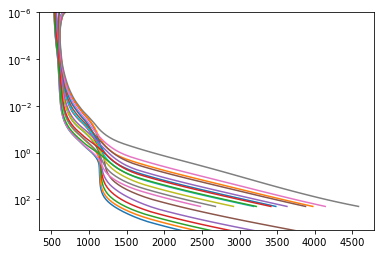

In [16]:
#T_int = np.array([100,200,300])
T_int=np.array([100,300,500])
grav = np.array([5.62])
T_star,logg,metal,rstar = 3913.3,4.68,0.0,0.62
mh = np.array(['-1.0','-0.5','+0.0','+0.5','+1.0','+2.0'])
CtoO =np.array(['1.0'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.03845, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.5])

path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b/"

plt.ylim(2e3,1e-6)
      
for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        
                        
                        filename= path+"tpfile/tp_eq_planet_"+str(T_int[i])+"_grav_"+str(grav[j])+"_mh_"+mh[k]+"_CO_"+CtoO[l]+"_sm_"+str(semi_major_ar[m])+"_v_"+str(rfacv[o])+"_.dat"
                        pres,temp = np.loadtxt(filename,usecols=[0,1],unpack=True)
                        
                        plt.semilogy(temp,pres)
                        
                        
                        

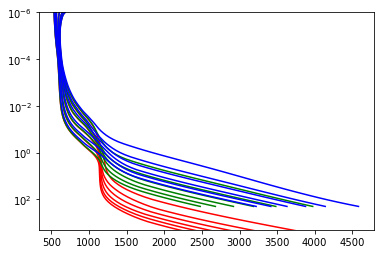

In [19]:
import pandas as pd
T_int=np.array([100,300,500])
grav = np.array([5.62])
T_star,logg,metal,rstar = 3913.3,4.68,0.0,0.62
mh = np.array(['-1.0','-0.5','+0.0','+0.5','+1.0','+2.0'])
CtoO =np.array(['1.0'])

a,e = 0.03845, 0
cosv = np.array([0])
semi_major_ar = np.array([a])
rfacv = np.array([0.5])

path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b/"

plt.ylim(2e3,1e-6)
      
for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        
                        
                        filename= path+"profile/profile_eq_planet_"+str(T_int[i])+"_grav_"+str(grav[j])+"_mh_"+mh[k]+"_CO_"+CtoO[l]+"_sm_"+str(semi_major_ar[m])+"_v_"+str(rfacv[o])+"_.dat"
                        
                        df = pd.read_csv(filename, sep='\t')
                        if T_int[i] == 100:
                            plt.semilogy(df['temperature'],df['pressure'],"r")
                        elif T_int[i] == 300 :
                            plt.semilogy(df['temperature'],df['pressure'],"g")
                            
                        elif T_int[i] == 500 :
                            plt.semilogy(df['temperature'],df['pressure'],"b")
                            
                        
                        
                        

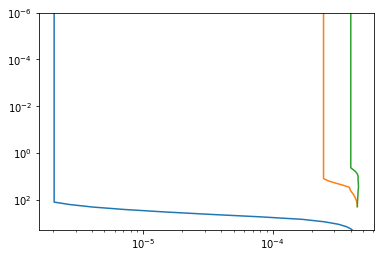

In [13]:
import pandas as pd
#T_int = np.array([100,200,300])
T_int=np.array([100,300,500])
grav = np.array([5.62])
T_star,logg,metal,rstar = 3913.3,4.68,0.0,0.62
mh = np.array(['+0.0'])
CtoO =np.array(['1.0'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.03845, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.5])
kzz = np.array([1e10])
path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b/"

plt.ylim(2e3,1e-6)
      
for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        for n in range(len(kzz)):
                        
                        
                        #filename= path+"tpfile/tp_deq_planet_"+str(T_int[i])+"_grav_"+str(grav[j])+"_mh_"+mh[k]+"_CO_"+CtoO[l]+"_sm_"+str(semi_major_ar[m])+"_v_"+str(rfacv[o])+"_.dat"
                        #pres,temp = np.loadtxt(filename,usecols=[0,1],unpack=True)
                            filename= path+"profile/profile_deq_planet_"+str(T_int[i])+"_grav_"+str(grav[j])+"_kzz_"+"1e"+str(int(np.log10(kzz[n])))+"_mh_"+mh[k]+"_CO_"+CtoO[l]+"_sm_"+str(semi_major_ar[m])+"_v_"+str(rfacv[o])+"_.dat"
                            df = pd.read_csv(filename,delimiter="\t")
                            plt.loglog(df['CO'],df['pressure'])
                            
                        
                        

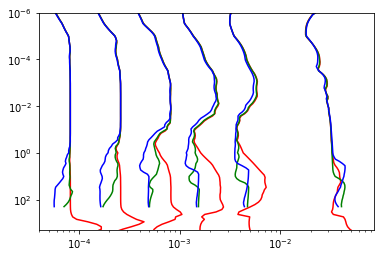

In [20]:

#T_int = np.array([100,200,300])
T_int=np.array([100,300,500])
grav = np.array([5.62])
T_star,logg,metal,rstar = 3913.3,4.68,0.0,0.62
mh = np.array(['-1.0','-0.5','+0.0','+0.5','+1.0','+2.0'])
CtoO =np.array(['1.0'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.03845, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.5])

path = "/Users/sagnickmukherjee/Documents/research/geers/toi3757b/"

plt.ylim(2e3,1e-6)
      
for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        
                        
                        filename= path+"profile/profile_eq_planet_"+str(T_int[i])+"_grav_"+str(grav[j])+"_mh_"+mh[k]+"_CO_"+CtoO[l]+"_sm_"+str(semi_major_ar[m])+"_v_"+str(rfacv[o])+"_.dat"
                        
                        df = pd.read_csv(filename, sep='\t')
                        if T_int[i] == 100:
                            plt.loglog(df['H2O'],df['pressure'],"r")
                        elif T_int[i] == 300 :
                            plt.loglog(df['H2O'],df['pressure'],"g")
                            
                        elif T_int[i] == 500 :
                            plt.loglog(df['H2O'],df['pressure'],"b")
                            
                        
                        
                        